[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RichardJPovinelli/Neural_Networks_Course/blob/main/Advanced_GNN.ipynb)

# 1. Overview
Compare GIN, GraphSAGE, and GAT; pooling; over-smoothing demo.

**TODO (students):**
- Read the notebook top to bottom once to understand the flow.
- Ensure dependencies are installed and kernel is ready. (Suggested: use the included `install_pyg_gpu_cu118.ps1` script if on Windows with GPU.)
- Run the dataset-loading cell and inspect dataset summaries.

In [70]:
# Colab helper: install wheel dependencies if running in Google Colab


import sys, subprocess, importlib


# Try to detect if we're running inside Google Colab
try:
    import google.colab  # type: ignore
    print("Detected Google Colab environment — ensuring required packages are installed...")
    # Check for required modules; if missing, we'll pip install appropriate packages
    %pip install torch torchvision torchaudio, torch-scatter, torch-sparse, torch-cluster, torch-spline-conv, torch-geometric
    print("Colab dependency installation completed — import cells can now run.")
except Exception:
    print("Not running inside Google Colab — assuming local environment has required packages.")
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv, global_mean_pool
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Not running inside Google Colab — assuming local environment has required packages.


## 2. Load Datasets


### Transductive Benchmark Datasets
- **Cora:** 2,708 machine-learning papers; 7 classes; 1,433 sparse word-frequency features; 5,429 citation edges.
- **CiteSeer:** 3,327 research publications; 6 topic labels; 3,703 binary word features; 4,732 citation links.
- **PubMed:** 19,717 biomedical articles; 3 disease classes; 500 TF-IDF features; 44,338 citation pairs.

All three share the standard Planetoid splits with 20 training nodes per class, 500 validation nodes, and 1,000 test nodes to facilitate direct model comparison.

In [71]:
datasets = {}
for name in ["Cora", "CiteSeer", "PubMed"]:
    datasets[name] = Planetoid(root=f"./{name}", name=name)  # store the dataset object (not dataset[0])

print({name: (ds[0].num_nodes, ds[0].num_edges, ds.num_node_features, ds.num_classes) for name, ds in datasets.items()})


{'Cora': (2708, 10556, 1433, 7), 'CiteSeer': (3327, 9104, 3703, 6), 'PubMed': (19717, 88648, 500, 3)}


## 3. Define Models

This section defines model classes and the math behind the architectures.

### 3.1 GraphSAGE: Equations & Intuition
- **Neighborhood sampling:** $S_v^{(k)} = \text{Sample}(\mathcal{N}(v), K)$
- **Mean aggregator:** $\text{AGG}^{(k)}(v) = \frac{1}{|S_v^{(k)}|} \sum\limits_{u \in S_v^{(k)}} h_u^{(k)}$
- **Pooling aggregator:** $\text{AGG}^{(k)}(v) = \max\limits_{u\in S_v^{(k)}} \sigma\!\left(W_\text{pool}^{(k)} h_u^{(k)} + b\right)$
- **Node update:** $h_v^{(k+1)} = \sigma\!\left(W^{(k)} \cdot [h_v^{(k)} \Vert \text{AGG}^{(k)}(v)]\right)$

**TODO:**
- Try the mean and pooling aggregators and compare the learned embeddings for a tracked node.
- Visualize neighbor sets and their embeddings for a chosen node.

### 3.2 GraphSAGE Internals Walkthrough
The cells below implement a "verbose" GraphSAGE layer that explicitly shows neighborhood sampling, mean aggregation, optional max-pooling, and the node update step so you can trace each intermediate tensor.

**TODO:**
- Run the verbose inspector for different `node_id` and `sample_size` values and note how aggregators change.
- Modify the `GraphSAGEVerboseLayer` to compute both mean and pooling at once and compare outputs.

In [72]:
class GraphSAGEVerboseLayer(nn.Module):
    """Pedagogical layer that surfaces each GraphSAGE sub-step."""
    def __init__(self, in_ch: int, hid: int):
        super().__init__()
        self.self_linear = nn.Linear(in_ch, hid)
        self.aggregate_linear = nn.Linear(in_ch, hid)
        self.update_linear = nn.Linear(2 * hid, hid)
        self.pool_linear = nn.Linear(in_ch, hid)
    def forward(self, data, node_id: int, sample_size: int = 5):
        edge_index = data.edge_index
        src, dst = edge_index
        all_neighbors = torch.unique(src[dst == node_id])
        debug = {
            "neighbors": all_neighbors.tolist() if all_neighbors.numel() > 0 else []
        }
        if all_neighbors.numel() == 0:
            sampled = all_neighbors
        elif sample_size is None or all_neighbors.numel() <= sample_size:
            sampled = all_neighbors
        else:
            perm = torch.randperm(all_neighbors.numel())[:sample_size]
            sampled = all_neighbors[perm]
        debug["sampled_neighbors"] = sampled.tolist() if sampled.numel() > 0 else []
        if sampled.numel() == 0:
            sampled_feats = data.x.new_zeros((1, data.x.size(1)))
        else:
            sampled_feats = data.x[sampled]
        mean_raw = sampled_feats.mean(dim=0)
        pool_proj = torch.relu(self.pool_linear(sampled_feats))
        pool_hidden = pool_proj.max(dim=0).values
        self_part = self.self_linear(data.x[node_id])
        mean_hidden = self.aggregate_linear(mean_raw)
        concat = torch.cat([self_part, mean_hidden], dim=0)
        updated = torch.relu(self.update_linear(concat))
        debug.update({
            "mean_raw": mean_raw.detach().cpu(),
            "mean_hidden": mean_hidden.detach().cpu(),
            "pool_hidden": pool_hidden.detach().cpu(),
            "concat": concat.detach().cpu(),
            "updated": updated.detach().cpu()
        })
        return updated, debug

def show_graphsage_internals(ds_name: str = "Cora", node_id: int = 42, sample_size: int = 5, seed: int = 0):
    torch.manual_seed(seed)
    dataset = datasets[ds_name]  # Planetoid dataset object
    data = dataset[0]  # Data object from dataset
    layer = GraphSAGEVerboseLayer(data.num_node_features, 32)
    updated, info = layer(data, node_id=node_id, sample_size=sample_size)
    print(f"Dataset: {ds_name}")
    print(f"Target node: {node_id}")
    print(f"Neighbors ({len(info['neighbors'])}): {info['neighbors']}")
    print(f"Sampled ({len(info['sampled_neighbors'])}): {info['sampled_neighbors']}")
    mean_preview = [round(v, 4) for v in info["mean_raw"][:5].tolist()]
    pool_preview = [round(v, 4) for v in info["pool_hidden"][:5].tolist()]
    updated_preview = [round(v, 4) for v in info["updated"][:5].tolist()]
    print(f"Mean aggregator (first 5 dims): {mean_preview}")
    print(f"Pooling aggregator (first 5 dims): {pool_preview}")
    print(f"Updated embedding (first 5 dims): {updated_preview}")

In [73]:
# Example inspection: adjust node_id/sample_size to explore other neighborhoods
show_graphsage_internals(ds_name="Cora", node_id=42, sample_size=6, seed=7)

Dataset: Cora
Target node: 42
Neighbors (2): [87, 1372]
Sampled (2): [87, 1372]
Mean aggregator (first 5 dims): [0.0, 0.0, 0.0, 0.0, 0.0]
Pooling aggregator (first 5 dims): [0.0124, 0.0329, 0.0, 0.0024, 0.0]
Updated embedding (first 5 dims): [0.0995, 0.0, 0.0, 0.0, 0.0313]


### 3.3 GAT: Equations & Intuition
- **Linear projection:** $h'_{i} = W h_{i}$
- **Attention logits:** $e_{ij} = \text{LeakyReLU}\!\left(a^{\top}[h'_i \Vert h'_j]\right)$ for $j \in \mathcal{N}(i)$
- **Normalized coefficients:** $\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum\limits_{k \in \mathcal{N}(i)} \exp(e_{ik})}$
- **Neighborhood aggregation:** $h^{(k+1)}_{i} = \sigma\!\left(\sum\limits_{j \in \mathcal{N}(i)} \alpha_{ij} h'_j\right)$
- **Multi-head fusion:** $h^{(k+1)}_{i} = \Vert_{m=1}^{M} \sigma\!\left(\sum\limits_{j \in \mathcal{N}(i)} \alpha^{(m)}_{ij} h'^{(m)}_j\right)$

**TODO (students):**
- Run the GAT verbose cell and inspect per-head attention coefficients for a chosen node.
- Compare attention distributions across heads and neighbors.

### 3.4 GAT Internals Walkthrough
This section implements a "verbose" GAT layer that exposes the linear projections, attention logits, normalized coefficients, and the per-head neighborhood aggregation for a single node so students can trace the full attention computation step-by-step.


In [74]:
class GATVerboseLayer(nn.Module):
    """Pedagogical GAT layer that shows per-head attention computations for a single node."""
    def __init__(self, in_ch:int, out_ch:int, heads:int=4, leaky_slope:float=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.heads = heads
        self.leaky_slope = leaky_slope
        # linear projection per head (no bias)
        self.projs = nn.ModuleList([nn.Linear(in_ch, out_ch, bias=False) for _ in range(heads)])
        # attention linear per head: maps concatenated [Wh_i || Wh_j] to a score
        self.attn = nn.ModuleList([nn.Linear(2 * out_ch, 1, bias=False) for _ in range(heads)])
    def forward(self, data, node_id:int, sample_size:int=None, return_per_head=False):
        edge_index = data.edge_index
        src, dst = edge_index
        all_neighbors = torch.unique(src[dst == node_id])
        info = {
            'neighbors': all_neighbors.tolist() if all_neighbors.numel() > 0 else []
        }
        # sample neighbors for pedagogy if requested (none -> all)
        if all_neighbors.numel() == 0:
            sampled = all_neighbors
        elif sample_size is None or all_neighbors.numel() <= sample_size:
            sampled = all_neighbors
        else:
            idx = torch.randperm(all_neighbors.numel())[:sample_size]
            sampled = all_neighbors[idx]
        info['sampled_neighbors'] = sampled.tolist() if sampled.numel() > 0 else []
        # Project features for all nodes for each head
        projections = []
        for h in range(self.heads):
            projections.append(self.projs[h](data.x))  # (N, out_ch) per head
        head_outputs = []
        head_info = []
        for h in range(self.heads):
            proj = projections[h]
            if sampled.numel() == 0:
                # no neighbors: aggregated vector is zero vector
                agg = proj.new_zeros(self.out_ch)
                e_logits = torch.tensor([])
                alphas = torch.tensor([])
            else:
                neigh_proj = proj[sampled]  # (n_neighbors, out_ch)
                node_proj = proj[node_id].unsqueeze(0).repeat(neigh_proj.size(0), 1)  # (n_neighbors, out_ch)
                concat = torch.cat([node_proj, neigh_proj], dim=1)  # (n_neighbors, 2*out_ch)
                e = F.leaky_relu(self.attn[h](concat).view(-1), negative_slope=self.leaky_slope)  # (n_neighbors,)
                alpha = torch.softmax(e, dim=0)
                agg = (alpha.unsqueeze(1) * neigh_proj).sum(dim=0)  # (out_ch,)
                e_logits = e.detach().cpu()
                alphas = alpha.detach().cpu()
            head_outputs.append(agg)
            head_info.append({'e_logits': e_logits, 'alphas': alphas, 'head_proj_node': projections[h][node_id].detach().cpu(), 'head_agg': agg.detach().cpu()})
        # final output: concatenate heads (common in GAT before final projection)
        final = torch.cat([h.unsqueeze(0) for h in head_outputs], dim=0).view(-1)  # combined vector (heads*out_ch,)
        info['heads'] = head_info
        info['final'] = final.detach().cpu()
        if return_per_head:
            return final, info, head_outputs
        return final, info


def show_gat_internals(ds_name:str='Cora', node_id:int=42, heads:int=4, sample_size:int=8, seed:int=0):
    torch.manual_seed(seed)
    dataset = datasets[ds_name]
    data = dataset[0]
    layer = GATVerboseLayer(data.num_node_features, 8, heads=heads)  # use small out_ch for demonstration
    final, info = layer(data, node_id=node_id, sample_size=sample_size)
    print(f"Dataset: {ds_name}")
    print(f"Target node: {node_id}")
    neighbors = info['neighbors']
    sampled = info['sampled_neighbors']
    print(f"Neighbors ({len(neighbors)}): {neighbors}")
    print(f"Sampled ({len(sampled)}): {sampled}")
    for i, h in enumerate(info['heads']):
        logits_preview = [round(float(x),4) for x in h['e_logits'][:6]] if h['e_logits'].numel() else []
        alpha_preview = [round(float(x),4) for x in h['alphas'][:6]] if h['alphas'].numel() else []
        proj_preview = [round(float(x),4) for x in h['head_proj_node'][:6]]
        agg_preview = [round(float(x),4) for x in h['head_agg'][:6]] if h['head_agg'].numel() else []
        print(f"Head {i}: proj (first 6 dims): {proj_preview}")
        print(f"Head {i}: logits (first {min(6,len(logits_preview))}): {logits_preview}")
        print(f"Head {i}: alphas (first {min(6,len(alpha_preview))}): {alpha_preview}")
        print(f"Head {i}: aggregated (first 6 dims): {agg_preview}")
    final_preview = [round(float(x),4) for x in info['final'][:12]]
    print(f"Concatenated final (first 12 dims): {final_preview}")

In [75]:
# Example demo: show the internals of a GAT layer for a selected node
show_gat_internals(ds_name='Cora', node_id=42, heads=4, sample_size=6, seed=7)

Dataset: Cora
Target node: 42
Neighbors (2): [87, 1372]
Sampled (2): [87, 1372]
Head 0: proj (first 6 dims): [0.0168, 0.0614, -0.1308, 0.0542, -0.074, -0.0266]
Head 0: logits (first 2): [0.0006, 0.0484]
Head 0: alphas (first 2): [0.4881, 0.5119]
Head 0: aggregated (first 6 dims): [-0.0253, 0.0914, -0.1087, 0.0093, 0.0531, 0.0966]
Head 1: proj (first 6 dims): [-0.0245, -0.1297, -0.0513, 0.0014, -0.0125, 0.0115]
Head 1: logits (first 2): [-0.0022, 0.013]
Head 1: alphas (first 2): [0.4962, 0.5038]
Head 1: aggregated (first 6 dims): [-0.0581, -0.1167, -0.0206, -0.047, -0.0507, 0.011]
Head 2: proj (first 6 dims): [0.036, 0.098, -0.0516, 0.0863, 0.0216, 0.014]
Head 2: logits (first 2): [-0.0008, -0.0006]
Head 2: alphas (first 2): [0.5, 0.5]
Head 2: aggregated (first 6 dims): [0.0588, -0.0387, 0.0047, 0.0414, 0.0406, -0.019]
Head 3: proj (first 6 dims): [0.0271, 0.0365, -0.0311, 0.0632, 0.0048, 0.1011]
Head 3: logits (first 2): [-0.0011, 0.0199]
Head 3: alphas (first 2): [0.4948, 0.5052]
Head

### 3.5 GIN: Equations & Intuition
- **Neighbor aggregation:** $h_{\mathcal{N}(v)}^{(k)} = \sum\limits_{u \in \mathcal{N}(v)} h_u^{(k)}$
- **Epsilon-adjusted sum:** $s_v^{(k)} = (1 + \epsilon^{(k)}) h_v^{(k)} + h_{\mathcal{N}(v)}^{(k)}$
- **MLP update:** $h_v^{(k+1)} = \text{MLP}^{(k)}\!\left(s_v^{(k)}\right)$
- **Optional readout:** $h_{\mathcal{G}} = \text{READOUT}\left(\{h_v^{(K)} \mid v \in \mathcal{V}\}\right)$

**TODO (students):**
- Try enabling `learn_eps=True` in the `GINVerboseLayer` and observe how `eps` is learned during training or inspection.
- Compare the outputs for `eps=0` and `eps=0.1` for the same node.

### GIN Internals Walkthrough
This walkthrough implements a verbose GIN layer that explicitly performs neighbor summation, epsilon-adjusted self-weighting, and MLP update, showing intermediate tensors so students can track how the GIN update works for a selected node.

In [76]:
class GINVerboseLayer(nn.Module):
    """Pedagogical GIN layer: sum neighbors, add (1+eps)*x_v, pass through an MLP, and show internals."""
    def __init__(self, in_ch:int, hid:int, eps:float=0.0, learn_eps:bool=False):
        super().__init__()
        self.in_ch = in_ch
        self.hid = hid
        if learn_eps:
            self.eps = nn.Parameter(torch.tensor(float(eps)))
        else:
            self.eps = float(eps)
        # MLP matching the GIN architecture: two linear layers with ReLU
        self.mlp = nn.Sequential(nn.Linear(in_ch, hid), nn.ReLU(), nn.Linear(hid, hid))
    def forward(self, data, node_id:int, sample_size:int=None):
        edge_index = data.edge_index
        src, dst = edge_index
        all_neighbors = torch.unique(src[dst == node_id])
        info = {'neighbors': all_neighbors.tolist() if all_neighbors.numel() else []}
        # sample neighbors for demonstration if requested
        if all_neighbors.numel() == 0:
            sampled = all_neighbors
        elif sample_size is None or all_neighbors.numel() <= sample_size:
            sampled = all_neighbors
        else:
            perm = torch.randperm(all_neighbors.numel())[:sample_size]
            sampled = all_neighbors[perm]
        info['sampled_neighbors'] = sampled.tolist() if sampled.numel() else []
        if sampled.numel() == 0:
            neighbor_sum = data.x.new_zeros((data.x.size(1),))
        else:
            neighbor_sum = data.x[sampled].sum(dim=0)  # sum over neighbor feature vectors
        self_feat = data.x[node_id]
        if isinstance(self.eps, float):
            eps_val = self.eps
        else:
            eps_val = float(self.eps.detach().cpu()) if not self.eps.requires_grad else float(self.eps.detach().cpu())
        s_v = (1.0 + eps_val) * self_feat + neighbor_sum
        out = self.mlp(s_v)
        info.update({
            'neighbor_sum': neighbor_sum.detach().cpu(),
            'eps': float(eps_val),
            's_v': s_v.detach().cpu(),
            'out': out.detach().cpu()
        })
        return out, info


def show_gin_internals(ds_name:str='Cora', node_id:int=42, sample_size:int=8, eps:float=0.0, learn_eps:bool=False, seed:int=0):
    torch.manual_seed(seed)
    dataset = datasets[ds_name]
    data = dataset[0]
    layer = GINVerboseLayer(data.num_node_features, 32, eps=eps, learn_eps=learn_eps)
    out, info = layer(data, node_id=node_id, sample_size=sample_size)
    print(f"Dataset: {ds_name}")
    print(f"Target node: {node_id}")
    print(f"Neighbors ({len(info['neighbors'])}): {info['neighbors']}")
    print(f"Sampled ({len(info['sampled_neighbors'])}): {info['sampled_neighbors']}")
    neighbor_preview = [round(float(x),4) for x in info['neighbor_sum'][:5]]
    s_v_preview = [round(float(x),4) for x in info['s_v'][:5]]
    out_preview = [round(float(x),4) for x in info['out'][:5]]
    print(f"Neighbor sum (first 5 dims): {neighbor_preview}")
    print(f"(1+eps) * self + sum (first 5 dims): {s_v_preview}")
    print(f"MLP output (first 5 dims): {out_preview}")

In [77]:
# Demo for GIN internals — adjust node id, eps, or sample size to experiment
show_gin_internals(ds_name='Cora', node_id=42, sample_size=6, eps=0.0, learn_eps=False, seed=7)

Dataset: Cora
Target node: 42
Neighbors (2): [87, 1372]
Sampled (2): [87, 1372]
Neighbor sum (first 5 dims): [0.0, 0.0, 0.0, 0.0, 0.0]
(1+eps) * self + sum (first 5 dims): [0.0, 0.0, 0.0, 0.0, 0.0]
MLP output (first 5 dims): [0.1239, -0.0209, -0.0659, -0.1526, 0.0114]


### 7. PyTorch GNN Implementations
(Reference implementations used in this notebook) 

**TODO:**
- Compare the custom `Verbose` layers (GraphSAGEVerbose, GATVerbose, GINVerbose) to the built-in `GCNConv`, `SAGEConv`, `GATConv`, and `GINConv` implementations in PyG.
- Try rewriting one model using low-level PyG primitives for educational purposes.

In [78]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_ch, hid, out_ch):
        super().__init__()
        self.s1 = SAGEConv(in_ch, hid)
        self.s2 = SAGEConv(hid, out_ch)
    def forward(self, x, edge_index):
        x = F.relu(self.s1(x, edge_index))
        return self.s2(x, edge_index)

In [79]:
class GAT(torch.nn.Module):
    def __init__(self, in_ch, hid, out_ch):
        super().__init__()
        self.g1 = GATConv(in_ch, hid, heads=4)
        self.g2 = GATConv(4*hid, out_ch)
    def forward(self, x, edge_index):
        x = F.elu(self.g1(x, edge_index))
        return self.g2(x, edge_index)

In [80]:
class GIN(torch.nn.Module):
    def __init__(self, in_ch, hid, out_ch):
        super().__init__()
        self.g1 = GINConv(nn.Sequential(nn.Linear(in_ch, hid), nn.ReLU(), nn.Linear(hid, hid)))
        self.g2 = GINConv(nn.Sequential(nn.Linear(hid, hid), nn.ReLU(), nn.Linear(hid, hid)))
        self.head = nn.Linear(hid, out_ch)
    def forward(self, x, edge_index):
        x = F.relu(self.g1(x, edge_index))
        x = F.relu(self.g2(x, edge_index))
        return self.head(x)

## 4. Training Helper Function

This cell defines a `train()` helper that trains a model on a given `Data` object and returns the last output logits.

**TODO:**
- Modify the `train()` helper to accept different optimizers (SGD, AdamW) and compare training behavior.
- Add an LR scheduler and observe whether training becomes more stable for deeper models.

In [81]:
def train(model, data, epochs=60, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data = data.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.005)
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        opt.step()
    model = model.to("cpu")
    data = data.to("cpu")
    return out.to("cpu")


## 5. Train and Compare Models

This section trains all model classes and reports test accuracy for each dataset.

**TODO:**
- Try changing hidden sizes and the training epochs to see how accuracy varies.

Running depth sweep for dataset: Cora
  Depth: 1


  Depth: 2
  Depth: 3
  Depth: 3
  Depth: 4
  Depth: 4
  Depth: 5
  Depth: 5
  Depth: 6
  Depth: 6
Running depth sweep for dataset: CiteSeer
  Depth: 1
Running depth sweep for dataset: CiteSeer
  Depth: 1
  Depth: 2
  Depth: 2
  Depth: 3
  Depth: 3
  Depth: 4
  Depth: 4
  Depth: 5
  Depth: 5
  Depth: 6
  Depth: 6
Running depth sweep for dataset: PubMed
  Depth: 1
Running depth sweep for dataset: PubMed
  Depth: 1
  Depth: 2
  Depth: 2
  Depth: 3
  Depth: 3
  Depth: 4
  Depth: 4
  Depth: 5
  Depth: 5
  Depth: 6
  Depth: 6


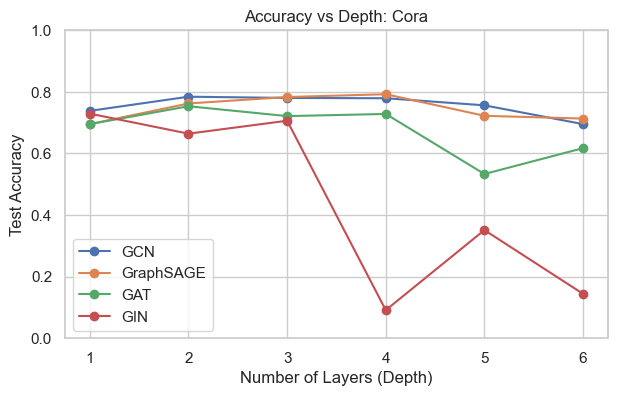

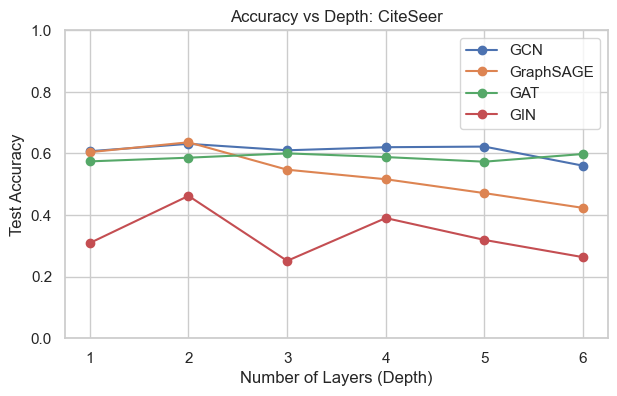

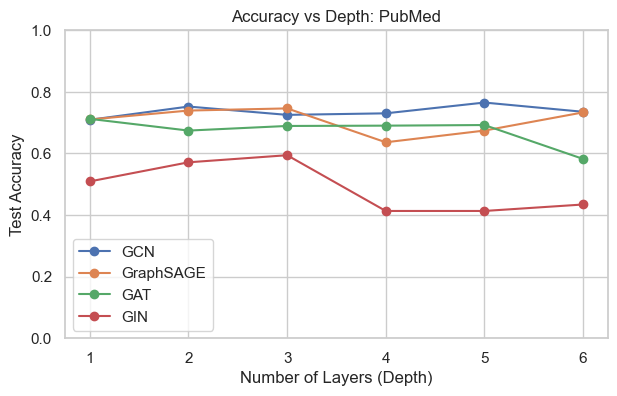

In [82]:
# Accuracy vs Depth experiments
import tqdm

def build_gcn_depth(in_ch, hid, out_ch, depth):
    class GCNDepth(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = torch.nn.ModuleList()
            if depth == 1:
                self.layers.append(GCNConv(in_ch, out_ch))
            else:
                self.layers.append(GCNConv(in_ch, hid))
                for _ in range(depth - 2):
                    self.layers.append(GCNConv(hid, hid))
                self.layers.append(GCNConv(hid, out_ch))
        def forward(self, x, edge_index):
            for i, layer in enumerate(self.layers):
                x = layer(x, edge_index) if i == (len(self.layers)-1) else F.relu(layer(x, edge_index))
            return x
    return GCNDepth

def build_sage_depth(in_ch, hid, out_ch, depth):
    class SAGEDepth(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = torch.nn.ModuleList()
            if depth == 1:
                self.layers.append(SAGEConv(in_ch, out_ch))
            else:
                self.layers.append(SAGEConv(in_ch, hid))
                for _ in range(depth - 2):
                    self.layers.append(SAGEConv(hid, hid))
                self.layers.append(SAGEConv(hid, out_ch))
        def forward(self, x, edge_index):
            for i, layer in enumerate(self.layers):
                x = layer(x, edge_index)
                if i != (len(self.layers)-1):
                    x = F.relu(x)
            return x
    return SAGEDepth

# Simplify GAT stacking: use single head per layer to make dimensions straightforward
from torch_geometric.nn import GATConv

def build_gat_depth(in_ch, hid, out_ch, depth, heads=1):
    class GATDepth(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = torch.nn.ModuleList()
            if depth == 1:
                self.layers.append(GATConv(in_ch, out_ch, heads=heads))
            else:
                self.layers.append(GATConv(in_ch, hid, heads=heads))
                for _ in range(depth - 2):
                    self.layers.append(GATConv(hid * heads, hid, heads=heads))
                self.layers.append(GATConv(hid * heads, out_ch, heads=1))
        def forward(self, x, edge_index):
            for i, layer in enumerate(self.layers):
                x = layer(x, edge_index)
                if i != (len(self.layers)-1):
                    x = F.elu(x)
            return x
    return GATDepth

# GIN depth builder
from torch_geometric.nn import GINConv

def build_gin_depth(in_ch, hid, out_ch, depth):
    class GINDepth(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = torch.nn.ModuleList()
            if depth == 1:
                self.layers.append(GINConv(nn.Sequential(nn.Linear(in_ch, out_ch), nn.ReLU(), nn.Linear(out_ch, out_ch))))
            else:
                self.layers.append(GINConv(nn.Sequential(nn.Linear(in_ch, hid), nn.ReLU(), nn.Linear(hid, hid))))
                for _ in range(depth - 2):
                    self.layers.append(GINConv(nn.Sequential(nn.Linear(hid, hid), nn.ReLU(), nn.Linear(hid, hid))))
                self.layers.append(GINConv(nn.Sequential(nn.Linear(hid, out_ch), nn.ReLU(), nn.Linear(out_ch, out_ch))))
        def forward(self, x, edge_index):
            for i, layer in enumerate(self.layers):
                x = layer(x, edge_index)
                if i != (len(self.layers)-1):
                    x = F.relu(x)
            return x
    return GINDepth


def accuracy_vs_depth(datasets, depth_range=range(1, 7), epochs=40, hidden_size=32, gat_hidden=8, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results_depth = {ds_name: { 'GCN': [], 'GraphSAGE': [], 'GAT': [], 'GIN': []} for ds_name in datasets.keys()}
    for ds_name, ds in datasets.items():
        print(f"Running depth sweep for dataset: {ds_name}")
        dataset = ds
        data = dataset[0]
        for depth in depth_range:
            print(f"  Depth: {depth}")
            # Build models for this depth
            GCNModel = build_gcn_depth(data.num_node_features, hidden_size, dataset.num_classes, depth)
            SAGEModel = build_sage_depth(data.num_node_features, hidden_size, dataset.num_classes, depth)
            GATModel = build_gat_depth(data.num_node_features, gat_hidden, dataset.num_classes, depth, heads=1)
            GINModel = build_gin_depth(data.num_node_features, hidden_size, dataset.num_classes, depth)

            models = {
                'GCN': GCNModel(),
                'GraphSAGE': SAGEModel(),
                'GAT': GATModel(),
                'GIN': GINModel()
            }

            for name, model in models.items():
                out = train(model, data, epochs=epochs, device=device)
                pred = out.argmax(dim=1)
                acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
                results_depth[ds_name][name].append(float(acc))
    return results_depth

# Run a quick sweep (smaller epochs so the interactive demo completes faster)
depth_range = range(1, 7)  # 1..6 layers
results_depth = accuracy_vs_depth(datasets, depth_range=depth_range, epochs=30, hidden_size=32, gat_hidden=8)

# Plotting Results: one panel per dataset showing accuracy vs depth for each model
import numpy as np

for ds_name, res in results_depth.items():
    plt.figure(figsize=(7,4))
    for model_name, accs in res.items():
        plt.plot(list(depth_range), accs, marker='o', label=model_name)
    plt.xlabel('Number of Layers (Depth)')
    plt.ylabel('Test Accuracy')
    plt.title(f'Accuracy vs Depth: {ds_name}')
    plt.ylim(0.0, 1.0)
    plt.xticks(list(depth_range))
    plt.grid(True)
    plt.legend()
    plt.show()

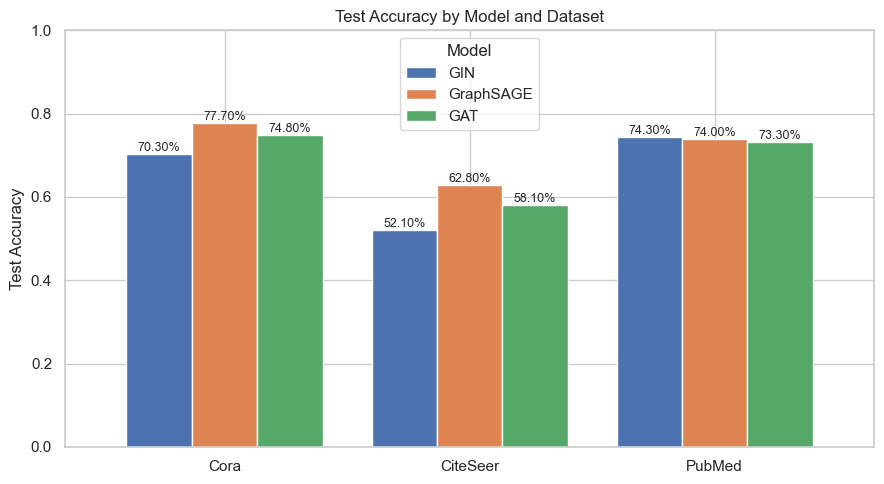

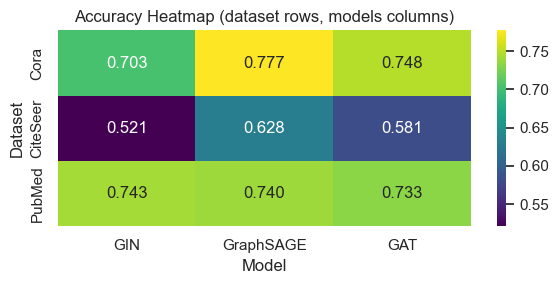

In [83]:
# Visualize test accuracy results across datasets and models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional; falls back to matplotlib if not present
sns.set_style('whitegrid')
%matplotlib inline

# Convert results to DataFrame: rows are datasets, cols are model names
df = pd.DataFrame.from_dict(results, orient='index')
# Reorder columns if needed - keep consistent model display order
model_order = ['GIN', 'GraphSAGE', 'GAT']
cols_to_plot = [c for c in model_order if c in df.columns]  # defensive ordering
df = df[cols_to_plot]

# Grouped bar chart: model accuracies per dataset
fig, ax = plt.subplots(figsize=(9, 5))
df.plot(kind='bar', ax=ax, rot=0, width=0.8)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy by Model and Dataset')
ax.legend(title='Model')
# Annotate the bars with percentage
for p in ax.patches:
    height = p.get_height()
    if height is not None and not (height != height):  # avoid NaN
        ax.annotate(f"{height:.2%}", (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

# Heatmap view for quick comparison (datasets x models)
plt.figure(figsize=(6, 3))
sns.heatmap(df, annot=True, fmt='.3f', cmap='viridis', cbar=True)
plt.title('Accuracy Heatmap (dataset rows, models columns)')
plt.xlabel('Model')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()

## 6. Over-Smoothing Demo

The demo below shows the standard deviation of node embeddings as the GCN layer is applied repeatedly.

**TODO (students):**
- Execute the over-smoothing demo for GCN, GraphSAGE, GAT and GIN (we added code for all of these) and plot the embedding standard deviation curves (already included in the notebook).
- Try dropout, residuals, and attention variants and observe how the std curves change.
- Compute mean pairwise cosine similarity across a subset of nodes as another measure of smoothing.

### Over-Smoothing: Intuition, Measurement & Mitigation

- **What is over-smoothing?**
  - Over-smoothing is the phenomenon where, as message-passing / graph convolutional layers are stacked, node embeddings become indistinguishable — i.e., they converge to a subspace where nodes in the graph (or even across communities) map to similar feature vectors. This typically causes a degradation in downstream performance on tasks that depend on node-level differentiation like node classification.

- **Why it happens (intuition):**
  - Many graph convolutional operators (e.g., GCN) act like low-pass filters on the graph: they mix a node's own features with its neighbors' features repeatedly. Repeating such filtering operations is like applying a smoothing operator many times, which reduces high-frequency (i.e., discriminative) components and increases low-frequency components shared by many nodes. Formally, repeated application of a normalized adjacency (or Laplacian-like) operator drives representations toward eigenvectors associated with the largest eigenvalues — information is lost for representations that need higher-frequency components.

- **Observables / How to measure it in practice:**
  - **Embedding Std per layer:** a simple test is to repeatedly apply the GNN layer (without training) and report the standard deviation across node embeddings at each layer — low std indicates collapsed/indistinguishable embeddings.
  - **Average pairwise cosine similarity:** compute mean pairwise cosine similarity (or a random subset for efficiency); an increase towards 1.0 indicates nodes are becoming more similar.
  - **Classification accuracy vs depth:** plot training or test accuracy as a function of the number of layers. If performance drops with increasing depth, over-smoothing may be one cause.
  - **Visualizations (PCA/t-SNE):** project embeddings from different layers to 2D to see whether clusters collapse as layers increase.
  - **Feature variance per feature-dimension:** monitor the per-dimension variance as layers grow.

- **Mitigation strategies (practical techniques):**
  - **Residual / skip connections** between layers (ResGCN, Skip connections / JKNet) to retain earlier information and break repeated mixing.
  - **Normalization** (BatchNorm / LayerNorm) per layer to stabilize learning and maintain variance.
  - **DropEdge** or stochastic edge removal to reduce excessive mixing per step.
  - **Attention mechanisms** (GAT) or per-edge weighting to focus information flow on key neighbors rather than uniformly pooling everything.
  - **Control the receptive field** using sampling (GraphSAGE) or limiting neighborhood depth and using local aggregators.
  - **Jump-Knowledge connections** to aggregate information from multiple layer depths rather than just final layer embeddings.
  - **Stronger, expressive aggregators** like GIN which may discriminate node neighborhoods better and be less prone to losing discriminative features when used carefully.
  - **Regularization & Task supervision** on intermediate layer outputs (auxiliary losses at intermediate layers) forcing earlier layers to preserve discriminative signal.
  - **Shallow networks** — sometimes reducing the number of layers is the simplest and most effective fix for over-smoothing in a given dataset.

- **Suggested experiments you can try in the notebook:**
  1. Repeat the current Std experiment for GCN, GraphSAGE, GAT and GIN and plot the Std curves to compare sensitivity to over-smoothing.
  2. Compute mean pairwise cosine similarity at each depth (or sample-subset for large graphs) and plot it to visualize how quickly similarity grows.
  3. For one dataset, compute test accuracy vs number of layers for each model and plot the curves.
  4. Add residual connections and repeat the Std/cosine similarity experiments to show how residuals slow down the smoothing.
  5. Visualize t-SNE/PCA of embeddings at depths {0, 1, 3, 6} and compare how clusters collapse or stay separated across different models.

> Tip: many of these experiments can be run quickly with a smaller `sampled` subset of nodes for similarity plotting to avoid O(N^2) cost.

- **Interpretation of the demo output:**
  - A falling STD (and rising mean pairwise similarity) means the model is mixing neighborhood information heavily and losing discriminative features between nodes. If accuracy drops as depth increases, it’s likely due to over-smoothing rather than insufficient capacity — try the mitigation strategies above to see their effect.

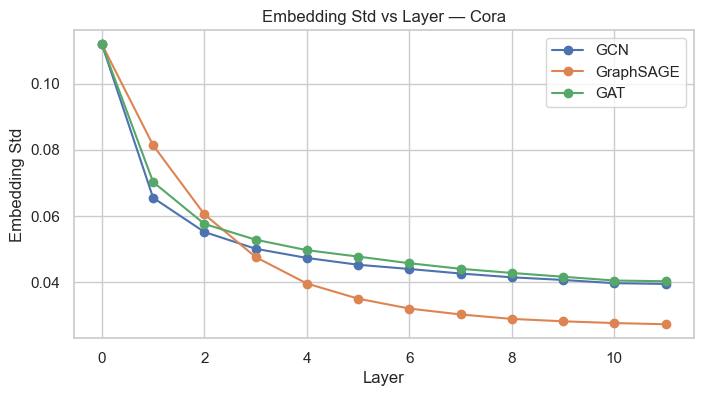

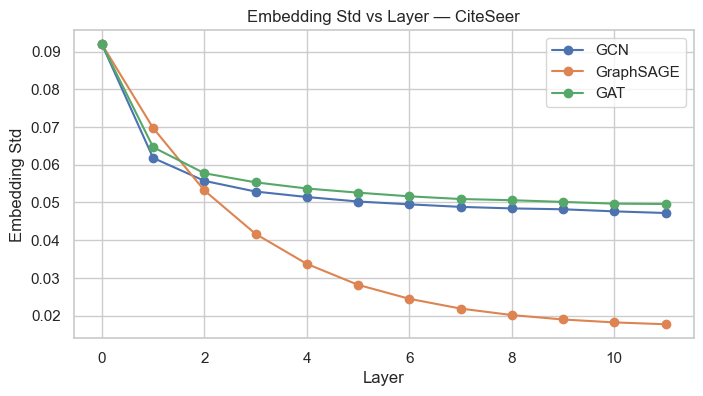

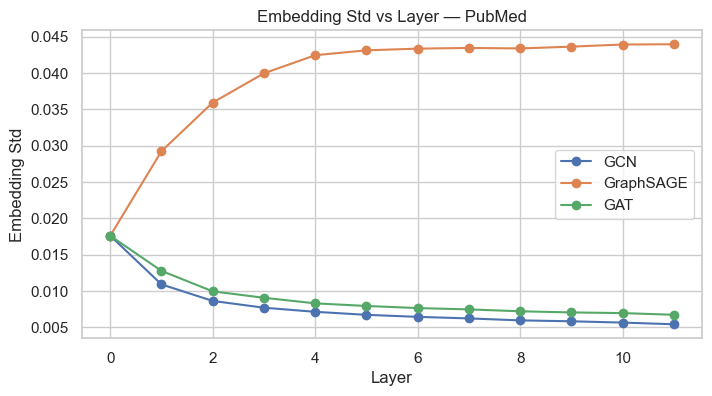

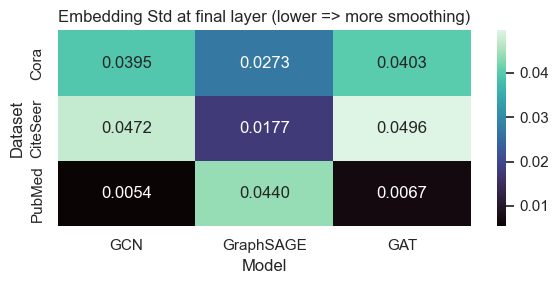

In [85]:
# Plotting Embedding Standard Deviation vs Layer for Each Model and Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
torch.manual_seed(0)  # reproducible demo
max_layers = 12
model_factories = {
    'GCN': lambda nf: GCNConv(nf, nf),
    'GraphSAGE': lambda nf: SAGEConv(nf, nf),
    'GAT': lambda nf: GATConv(nf, nf, heads=1),
}
results_std = {}
for ds_name, ds in datasets.items():
    dataset = ds
    data = dataset[0]
    nf = dataset.num_node_features
    results_std[ds_name] = {}
    for model_name, factory in model_factories.items():
        conv = factory(nf)
        x_curr = data.x.clone()
        stds = []
        with torch.no_grad():
            for layer in range(max_layers):
                stds.append(x_curr.std().item())
                x_curr = conv(x_curr, data.edge_index)
        results_std[ds_name][model_name] = stds
# Build DataFrame and plot per dataset
for ds_name, models in results_std.items():
    df = pd.DataFrame(models, index=list(range(max_layers)))
    plt.figure(figsize=(8, 4))
    for col in df.columns:
        plt.plot(df.index, df[col], marker='o', label=col)
    plt.xlabel('Layer')
    plt.ylabel('Embedding Std')
    plt.title(f'Embedding Std vs Layer — {ds_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
# Combined heatmap at max depth to compare models per dataset
final_stds = {ds_name: {m: vals[-1] for m, vals in models.items()} for ds_name, models in results_std.items()}
df_final = pd.DataFrame(final_stds).T  # datasets x models
plt.figure(figsize=(6, 3))
sns.heatmap(df_final, annot=True, fmt='.4f', cmap='mako')
plt.title('Embedding Std at final layer (lower => more smoothing)')
plt.xlabel('Model')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()